# **Statistical learning final project**: modelling

### Daniel A.
### UID: 100444499

### Importing libraries and setting options

In [1]:
library(dplyr)
library(MASS)
library(e1071) 
library(VGAM)
library(caret)
library(penalizedLDA)
library(klaR)
library(arm)
library(caTools)
library(stepPlr)
library(LiblineaR)
library(xgboost)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: stats4

Loading required package: splines

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:VGAM’:

    predictors


Loading required package: Matrix

Loading required package: lme4


arm (Version 1.11-2, built: 2020-7-27)


Working directory is /home/dreth/.local/share/Cryptomator/mnt/Onedrive/UC3M/COURSES/statistical learning/UC3MStatisticalLearning/notebooks



Attaching package: ‘arm’


The following object is masked from ‘package:VGAM’:

    logit



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [2]:
# turn off warnings
options(warn=-1)

### Importing the data

In [3]:
df = read.csv('../data/data.csv')

### Preparing training and target sets

In [4]:
# vars
vars = names(df)
# training vars
train = vars[6:(length(vars)-2)]
train = df %>% dplyr::select(train)
# saving train to csv
write.csv(train,'../data/final/train.csv')

# target var
target = vars[length(vars)]
target = df %>% dplyr::select(target)

# saving target to csv
target$hdi_cat <- as.factor(target$hdi_cat)
write.csv(target,'../data/final/target.csv')

# target for models
dep <- as.factor(levels(target$hdi_cat))


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(train)` instead of `train` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(target)` instead of `target` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [5]:
# leaving a dataset with everything included except IDs
data <- cbind(train,target)

## Model 1: Logistic Regression

We use 3 reps of 10-fold CV

In [6]:
control <- trainControl(method = "repeatedcv",
                        repeats = 3,
                        number = 10 )

Confusion Matrix and Statistics

           Reference
Prediction  high low medium very high
  high        47   0     10         8
  low          0  31      7         0
  medium       1   1     19         0
  very high    4   0      0        56

Overall Statistics
                                          
               Accuracy : 0.8315          
                 95% CI : (0.7695, 0.8826)
    No Information Rate : 0.3478          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7687          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: high Class: low Class: medium Class: very high
Sensitivity               0.9038     0.9688        0.5278           0.8750
Specificity               0.8636     0.9539        0.9865           0.9667
Pos Pred Value            0.7231     0.8158        0.9048           0.9333
Neg Pred Value            

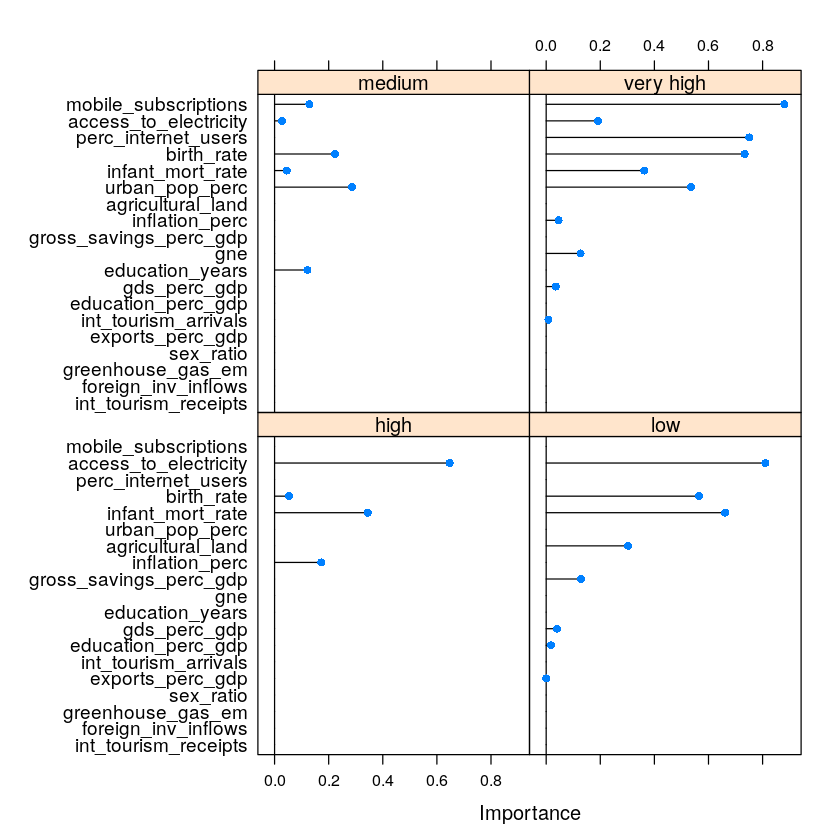

In [7]:
lrfit <- train(hdi_cat ~ ., 
               method = "glmnet",
               family = "multinomial",
               data = data,
               metric = "Accuracy",
               preProcess = c("center","scale"),
               tuneGrid = expand.grid(alpha = seq(0, 2, 0.1), 
                                      lambda = seq(0, .1, 0.01)),
               trControl = control)

lrpred <- predict(lrfit, data)
confusionMatrix(lrpred, data$hdi_cat)

lrimp <- varImp(lrfit, scale = F)
plot(lrimp, scales = list(y = list(cex = .95)))

## Model 2: Linear Discriminant Analysis

Confusion Matrix and Statistics

           Reference
Prediction  high low medium very high
  high        48   0      7         9
  low          0  29      5         0
  medium       3   3     24         0
  very high    1   0      0        55

Overall Statistics
                                          
               Accuracy : 0.8478          
                 95% CI : (0.7876, 0.8964)
    No Information Rate : 0.3478          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7921          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: high Class: low Class: medium Class: very high
Sensitivity               0.9231     0.9062        0.6667           0.8594
Specificity               0.8788     0.9671        0.9595           0.9917
Pos Pred Value            0.7500     0.8529        0.8000           0.9821
Neg Pred Value            

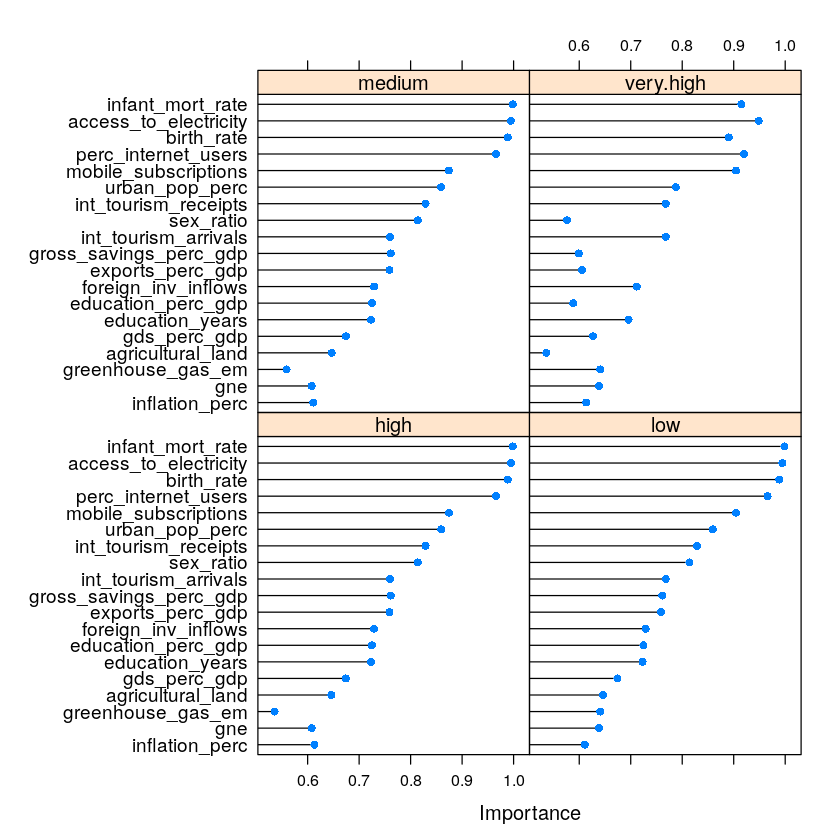

In [27]:
ldafit <- train(hdi_cat ~ ., 
                method = "lda", 
                data = data,
                preProcess = c("center", "scale"),
                metric = "Accuracy",
                trControl = control)

ldapred <- predict(ldafit, data)
confusionMatrix(ldapred, data$hdi_cat)

ldaimp <- varImp(ldafit, scale = F)
plot(ldaimp, scales = list(y = list(cex = .95)))

## Method 3: Boosted Logistic Regression

Confusion Matrix and Statistics

           Reference
Prediction  high low medium very high
  high        48   0      1         0
  low          0  30      0         0
  medium       0   0     29         0
  very high    1   0      0        63

Overall Statistics
                                          
               Accuracy : 0.9884          
                 95% CI : (0.9586, 0.9986)
    No Information Rate : 0.3663          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9839          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: high Class: low Class: medium Class: very high
Sensitivity               0.9796     1.0000        0.9667           1.0000
Specificity               0.9919     1.0000        1.0000           0.9908
Pos Pred Value            0.9796     1.0000        1.0000           0.9844
Neg Pred Value            

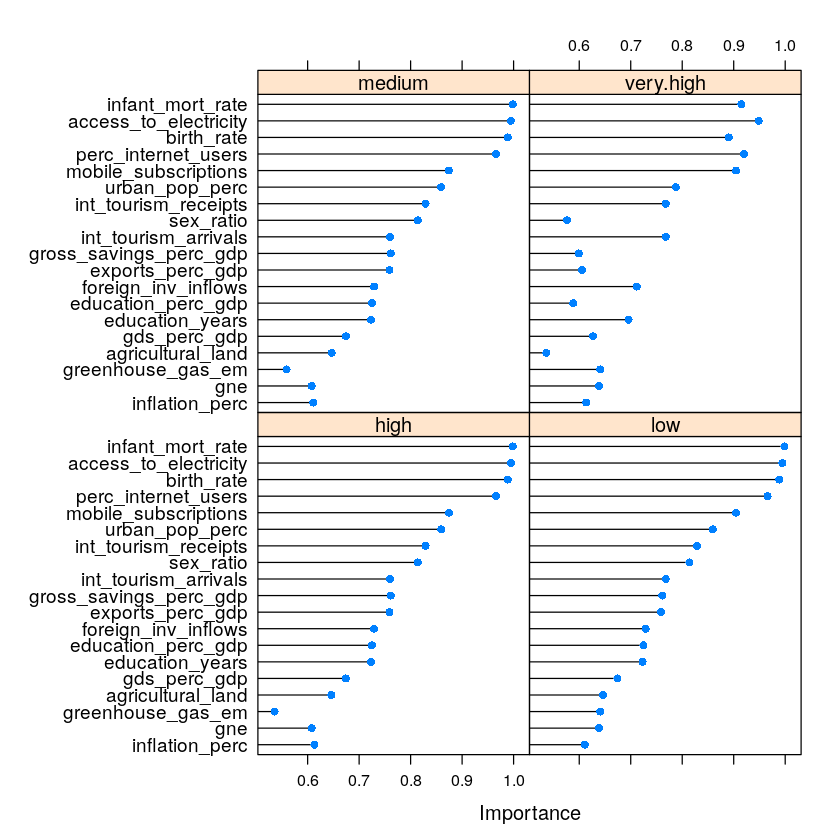

In [12]:
blrfit <- train(hdi_cat ~ ., 
                method = "LogitBoost", 
                data = data,
                preProcess = c("center", "scale"),
                metric = "Accuracy",
                trControl = control)

blrpred <- predict(blrfit, data)
confusionMatrix(blrpred, data$hdi_cat)

blrimp <- varImp(blrfit, scale = F)
plot(blrimp, scales = list(y = list(cex = .95)))

## Method 4: Quadratic Discriminant Analysis

Confusion Matrix and Statistics

           Reference
Prediction  high low medium very high
  high        45   0      1         5
  low          0  32      1         0
  medium       5   0     34         0
  very high    2   0      0        59

Overall Statistics
                                          
               Accuracy : 0.9239          
                 95% CI : (0.8756, 0.9578)
    No Information Rate : 0.3478          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8963          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: high Class: low Class: medium Class: very high
Sensitivity               0.8654     1.0000        0.9444           0.9219
Specificity               0.9545     0.9934        0.9662           0.9833
Pos Pred Value            0.8824     0.9697        0.8718           0.9672
Neg Pred Value            

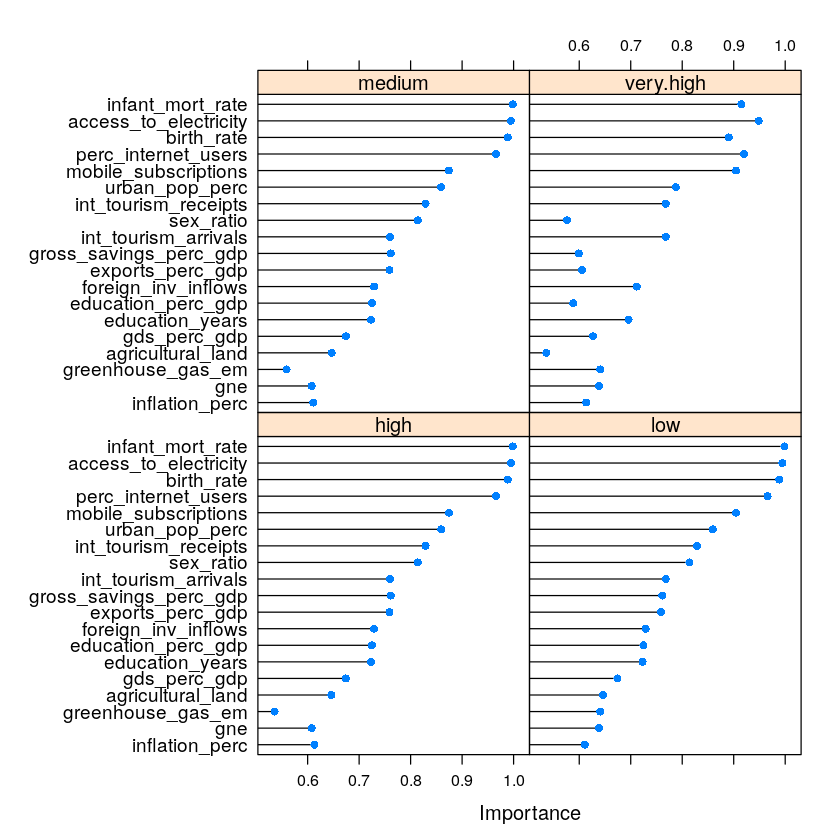

In [12]:
qdafit <- train(hdi_cat ~ ., 
                method = "qda", 
                data = data,
                preProcess = c("center", "scale"),
                metric = "Accuracy",
                trControl = control)

qdapred <- predict(qdafit, data)
confusionMatrix(qdapred, data$hdi_cat)

qdaimp <- varImp(qdafit, scale = F)
plot(qdaimp, scales = list(y = list(cex = .95)))

## Method 5: Regularized Discriminant Analysis

In [13]:
rdafit <- train(hdi_cat ~ ., 
                method = "rda", 
                data = data,
                preProcess = c("center", "scale"),
                metric = "Accuracy",
                tuneGrid = expand.grid(gamma = seq(0, 1, 0.2),
                    lambda = seq(0, 1, 0.2)),
                trControl = control)

rdapred <- predict(rdafit, data)
confusionMatrix(rdapred, data$hdi_cat)

rdaimp <- varImp(rdafit, scale = F)
plot(rdaimp, scales = list(y = list(cex = .95)))

## Method 6: Extreme Gradient Boosting

Confusion Matrix and Statistics

           Reference
Prediction  high low medium very high
  high        52   0      0         0
  low          0  32      0         0
  medium       0   0     36         0
  very high    0   0      0        64

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9802, 1)
    No Information Rate : 0.3478     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: high Class: low Class: medium Class: very high
Sensitivity               1.0000     1.0000        1.0000           1.0000
Specificity               1.0000     1.0000        1.0000           1.0000
Pos Pred Value            1.0000     1.0000        1.0000           1.0000
Neg Pred Value            1.0000     1.0000        1.0000           1.0

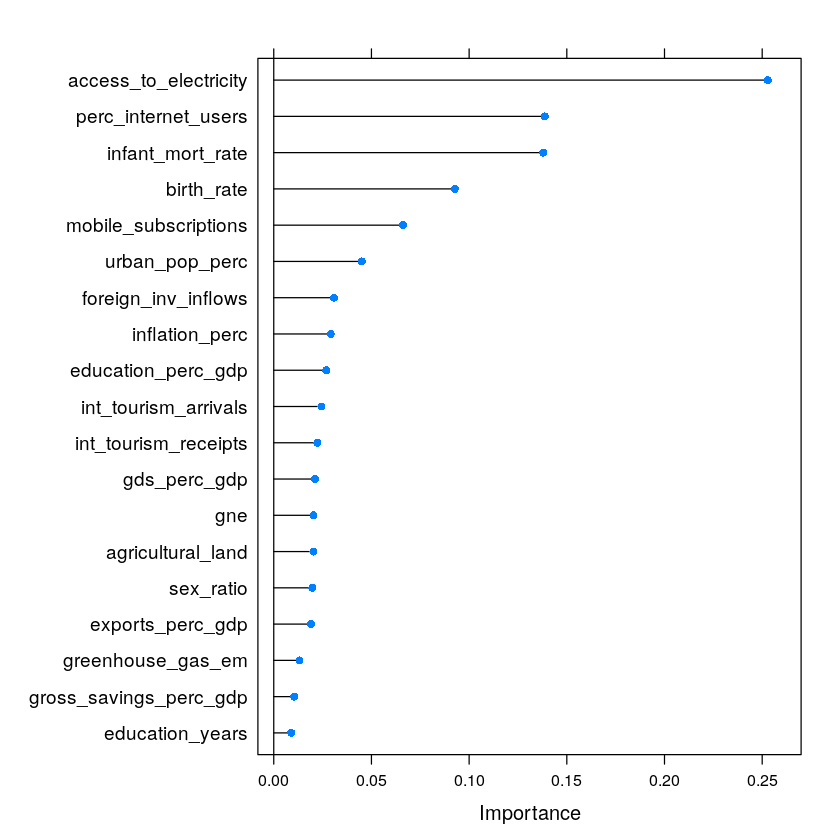

In [67]:
xgbfit <- train(hdi_cat ~ ., 
                method = "xgbDART", 
                data = data,
                preProcess = c("center", "scale"),
                metric = "Accuracy",
                trControl = control)

xgbpred <- predict(xgbfit, data)
confusionMatrix(xgbpred, data$hdi_cat)

xgbimp <- varImp(xgbfit, scale = F)
plot(xgbimp, scales = list(y = list(cex = .95)))

In [22]:
knnfit <- train(hdi_cat ~ ., 
                method = "knn", 
                data = data,
                preProcess = c("center", "scale"),
                metric = "Accuracy",
                trControl = control)

knnpred <- predict(knnfit, data)
knncm <- confusionMatrix(knnpred, data$hdi_cat)
knncm

Confusion Matrix and Statistics

           Reference
Prediction  high low medium very high
  high        45   0     11         9
  low          0  30     11         0
  medium       2   2     13         0
  very high    5   0      1        55

Overall Statistics
                                          
               Accuracy : 0.7772          
                 95% CI : (0.7101, 0.8351)
    No Information Rate : 0.3478          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6939          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: high Class: low Class: medium Class: very high
Sensitivity               0.8654     0.9375       0.36111           0.8594
Specificity               0.8485     0.9276       0.97297           0.9500
Pos Pred Value            0.6923     0.7317       0.76471           0.9016
Neg Pred Value            